In this lecture we study how to deal with imbalanced data. Imbalanced classification involves developing predictive models on classification datasets that have a severe class imbalance. The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of **data augmentation** for the minority class and is referred to as the **Synthetic Minority Oversampling Technique**, or **SMOTE** for short.

In this tutorial, we still study the SMOTE algorithm for oversampling imbalanced classification datasets. We follow the notes from the 'machine learning mastery' blog by Jason Brownlee from the website 'Machine Learning Mastery'. 

In [16]:
import imblearn
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline

%matplotlib inline

### I. Theories on SMOTE

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space through a convex combination:

   _"SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b."_
   
The approach is effective because new synthetic examples from the minority class are created that are plausible, that is, are relatively close in feature space to existing examples from the minority class. A general downside of the approach is that synthetic examples are created without considering the majority class, possibly resulting in ambiguous examples if there is a strong overlap for the classes.

The main library we will be using for imbalanced dataset is called 'imblearn'. We want to make sure that the version code is 0.7.0 or above. 

In [2]:
os.chdir("C:\\Users\\GAO\\GAO_Jupyter_Notebook\\Datasets")
print(imblearn.__version__)

0.7.0


### II. The Intuition Behind the Basic version of SMOTE

In this section, we will develop an intuition for the SMOTE by applying it to an imbalanced binary classification problem.

First, we can use the make_classification() scikit-learn function to create a synthetic binary classification dataset with 10,000 examples and a 1:100 class distribution:

In [17]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, 
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

We can use the Counter object to summarize the number of examples in each class to confirm the dataset was created correctly:

In [4]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 100})


we can create a scatter plot of the dataset and color the examples for each class a different color to clearly see the spatial nature of the class imbalance. A scatter plot of the dataset is then created showing the large mass of points that belong to the majority class (blue) and a small number of points spread out for the minority class (orange). As we can see below, some measure of overlap between the two classes also exists:

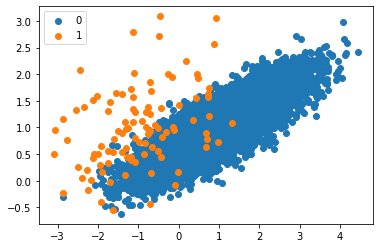

In [5]:
for label, _ in counter.items(): # scatterplot of examples by class label
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

Next, we can oversample the minority class using SMOTE and plot the transformed dataset.The 'SMOTE' class acts like a data transform object from scikit-learn in that it must be defined and configured,  fit on a dataset, then applied to create a new transformed version of the dataset.

For example, we can define a 'SMOTE' instance with default parameters that will balance the minority class and then fit and apply it in one step to create a transformed version of our dataset. Once transformed, we can summarize the class distribution of the new transformed dataset, which would expect to now be balanced through the creation of many new synthetic examples in the minority class:

In [6]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 9900})


A scatter plot of the transformed dataset can also be created and we would expect to see many more examples for the minority class on lines between the original examples in the minority class:

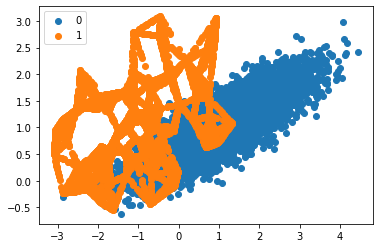

In [7]:
for label, _ in counter.items(): # scatterplot of examples by class label
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

There is certainly flexibility in choosing the ratio between the minority and majority classes. The original paper on SMOTE suggested combining SMOTE with random undersampling of the majority class.  For example, we can update the example above to first oversample the minority class to have 10 percent the number of examples of the majority class (e.g. about 1000 in total), then use random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class (e.g. about 2000 in total).

To implement this, we can specify the desired ratios as arguments to the SMOTE and the 'RandomUnderSampler' classes. We can then chain these two transforms together into a 'Pipeline', which can then be applied to a dataset, performing each transformation in turn and returning a final dataset with the accumulation of the transform applied to it, in this case oversampling followed by undersampling. The pipeline can then be fit and applied to our dataset just like a single transform. The codes are shown below:

Counter({0: 1980, 1: 990})


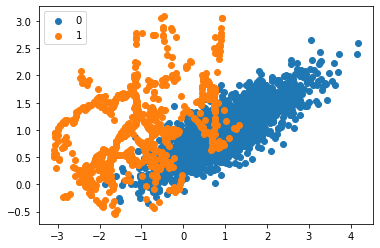

In [8]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)

counter = Counter(y)
print(counter) # summarizing the new class distribution

for label, _ in counter.items(): # scatterplot of examples by class label
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

### III. Extensions of Basic SMOTE

There are many other algorithms that grow upon the basic SMOTE algorithm. For example, a popular extension to SMOTE involves selecting those instances of the minority class that are misclassified, such as with a k-nearest neighbor classification model. We can then oversample just those difficult instances, providing more resolution only where it may be required. The idea is that the examples on the borderline and the ones nearby are in theory more apt to be misclassified than the ones far from the borderline, and thus more important for classification. These examples that are misclassified are likely ambiguous and in a region of the edge or border of decision boundary where class membership may overlap. As such, this modified to SMOTE is called **Borderline-SMOTE** and was proposed by Hui Han, et al.(2005). The key to remember is that instead of generating new synthetic examples for the minority class blindly, we would expect the Borderline-SMOTE method to only create synthetic examples along the decision boundary between the two classes.

Counter({0: 9900, 1: 9900})


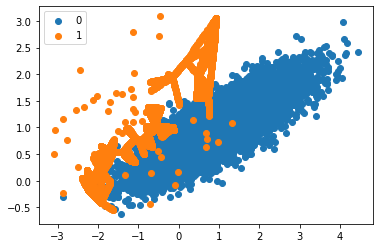

In [9]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

borderline_sm = BorderlineSMOTE()
X1, y1 = borderline_sm.fit_resample(X, y)

counter = Counter(y1)
print(counter) # summarizing the new class distribution

for label, _ in counter.items(): # scatterplot of examples by class label
    row_ix = np.where(y1 == label)[0]
    plt.scatter(X1[row_ix, 0], X1[row_ix, 1], label=str(label))
plt.legend()
plt.show()

A second extension is called **Borderline-SMOTE-SVM**. Hien Nguyen, et al.(2009) suggest using an alternative of Borderline-SMOTE where an SVM algorithm is used instead of a KNN to identify misclassified examples on the decision boundary. Their approach uses an SVM to locate the decision boundary defined by the support vectors and examples in the minority class that close to the support vectors become the focus for generating synthetic examples. In addition to using an SVM, the technique attempts to select regions where there are fewer examples of the minority class and tries to extrapolate towards the class boundary.

Counter({0: 9900, 1: 9900})


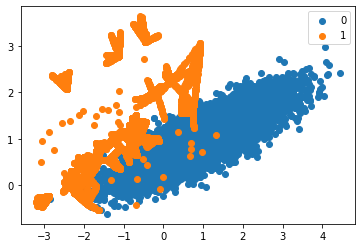

In [10]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

borderline_svm = SVMSMOTE()
X2, y2 = borderline_svm.fit_resample(X, y)

counter = Counter(y2)
print(counter) # summarizing the new class distribution

for label, _ in counter.items(): # scatterplot of examples by class label
    row_ix = np.where(y2 == label)[0]
    plt.scatter(X2[row_ix, 0], X2[row_ix, 1], label=str(label))
plt.legend()
plt.show()

Another approach involves generating synthetic samples inversely proportional to the density of the examples in the minority class. That is, generate more synthetic examples in regions of the feature space where the density of minority examples is low, and fewer or none where the density is high. This modification to SMOTE is referred to as the **Adaptive Synthetic Sampling Method**, or **ADASYN**, and was proposed to He (2008). According to the paper:

   _"ADASYN is based on the idea of adaptively generating minority data samples according to their distributions: more synthetic data is generated for minority class samples that are harder to learn compared to those minority samples that are easier to learn."_
   
   The rationale behind is that since examples in the minority class can be weighted according to their density, those examples with the lowest density are the focus for the SMOTE synthetic example generation process, here is what the author has to say:
   
   _"The key idea of ADASYN algorithm is to use a density distribution as a criterion to automatically decide the number of synthetic samples that need to be generated for each minority data example."_

Counter({0: 9900, 1: 9899})


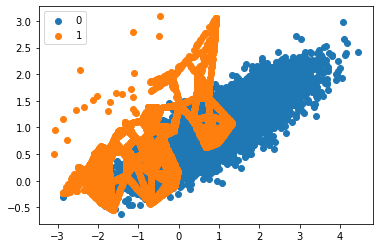

In [11]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

Adasyn = ADASYN()
X3, y3 = Adasyn.fit_resample(X, y)

counter = Counter(y3)
print(counter) # summarizing the new class distribution

for label, _ in counter.items(): # scatterplot of examples by class label
    row_ix = np.where(y3 == label)[0]
    plt.scatter(X3[row_ix, 0], X3[row_ix, 1], label=str(label))
plt.legend()
plt.show()

### IV. Applying SMOTE

Let's see a real example. First, let's fit a decision tree model without SMOTE. 

The algorithm is defined with any required hyperparameters (we will use the defaults), then we will use repeated stratified k-fold cross-validation to evaluate the model. We will use three repeats of 10-fold cross-validation, meaning that 10-fold cross-validation is applied three times fitting and evaluating 30 models on the dataset.

The dataset is stratified, meaning that each fold of the cross-validation split will have the same class distribution as the original dataset, in this case, a 1:100 ratio. We will evaluate the model using the ROC area under curve (AUC) metric. This can be optimistic for severely imbalanced datasets but will still show a relative change with better performing models.

In [12]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

model = DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.767


Now, we can try the same model and the same evaluation method, although use a SMOTE transformed version of the dataset.

The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, then evaluate the model on the stratified but non-transformed test set. This can be achieved by defining a pipeline that first transforms the training dataset with SMOTE then fits the model.

In [13]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps) # defining a pipeline

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.816


As mentioned in the paper, it is believed that SMOTE performs better when combined with undersampling of the majority class, such as random undersampling. We can achieve this by simply adding a RandomUnderSampler() step to the pipeline. So let's retry: we will first oversample the minority class with SMOTE to about a 1:10 ratio, then undersample the majority class to achieve about a 1:2 ratio.

In [14]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

model = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.836


Another area to explore would be to test different values of the k-nearest neighbors selected in the SMOTE procedure when each new synthetic example is created. The default is k=5, although larger or smaller values will influence the types of examples created, and in turn, may impact the performance of the model.

For example, we could grid search a range of values of k, such as values from 1 to 7, and evaluate the pipeline for each value:

In [15]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.831
> k=2, Mean ROC AUC: 0.838
> k=3, Mean ROC AUC: 0.826
> k=4, Mean ROC AUC: 0.844
> k=5, Mean ROC AUC: 0.827
> k=6, Mean ROC AUC: 0.840
> k=7, Mean ROC AUC: 0.849


References:
   - https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
   - https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
   - https://arxiv.org/abs/1106.1813
   - http://ousar.lib.okayama-u.ac.jp/en/19617
   - He, HaiBo, Yun, QianMa" (2013). Imbalanced Learning: Foundations, Algorithms, and Applications". Wiley.
   - Han H., Wang WY., Mao BH. (2005) Borderline-SMOTE: A New Over-Sampling Method in Imbalanced Data Sets Learning. In: Huang DS., Zhang XP., Huang GB. (eds) Advances in Intelligent Computing. ICIC 2005. Lecture Notes in Computer Science, vol 3644. Springer, Berlin, Heidelberg.
   - Haibo He, Yang Bai, E. A. Garcia and Shutao Li, "ADASYN: Adaptive synthetic sampling approach for imbalanced learning," 2008 IEEE International Joint Conference on Neural Networks (IEEE World Congress on Computational Intelligence), Hong Kong, 2008, pp. 1322-1328.